In [54]:
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Seq import reverse_complement
from Bio.SeqUtils import GC

## Load existing readouts

In [9]:
import pandas as pd
import numpy as np
import os, sys
from tqdm.notebook import tqdm

readout_folder = r'/lab/solexa_weissman/puzheng/References/Readouts'
existing_readout_df = pd.read_excel(os.path.join(readout_folder, 'Chromatin_Libraries.xlsx'), 'Readouts')

In [4]:
# import count-table
from importlib import reload
# this version doesn't have ChromAn compiled, so directly load from src:
#sys.path.append(r"/home/puzheng/Softwares")
import MERFISH_probe_design.probe_design.OTTable_dict as ot

readout_seqs = [_s for _s in existing_readout_df['Sequence'] if isinstance(_s, str)]
readout_seqs_rc = [reverse_complement(_s) for _s in readout_seqs]

readout_keylen = 15
readout_table = ot.get_OTTable_for_sequences(readout_seqs + readout_seqs_rc,
                             readout_keylen, verbose=True)

Processed 1000/3658 sequences.
Processed 2000/3658 sequences.
Processed 3000/3658 sequences.


In [20]:
# this version doesn't have ChromAn compiled, so directly load from src:
sys.path.append(r"/lab/weissman_imaging/puzheng/Softwares/ChromAn")
import src
reload(src)

<module 'src' from '/lab/weissman_imaging/puzheng/Softwares/ChromAn/src/__init__.py'>

# Download 24,000 orthogonal 25mer sequences used to design NDBs:
https://elledge.hms.harvard.edu/?page_id=638

https://www.pnas.org/doi/abs/10.1073/pnas.0812506106


In [5]:

bc25mer_filename = os.path.join(readout_folder, 'bc25mer.240k.fasta')

barcodes = []

with open(bc25mer_filename, 'r') as _handle:
    for _record in SeqIO.parse(_handle, "fasta"):
        barcodes.append(_record)
print(len(barcodes))

240000



## Acoording to previous records, I used ~ first 6000 to generate NDB readouts

Therefore, I will start from the middle:

In [7]:
# T7, T3, T3ext, PacIsite
upstream_seq = 'cgcctccccgcatcgatacctaatacgactcactatagggagagtaattaaccctcactaaagggataatttaattaa' 
# 120nt MERFISH intBC here:

# sequencing primer in the middle:
primer_10x = 'gaatccagctagctgtgcagc'
# 30nt intBC here:

# PacI site again, RNF2 full casette
downstream_seq = 'ttaattaatggcagtcatcttagtcattacgacaggtgttcgttgtaactcatata'

# masked sequences:
masked_seqs = ['AAAAA', 'CCCCC', 'GGGGG', 'TTTTT', 'ttaattaa']

In [11]:
readout_table

{'ATCCTCCTTCAATAC': 1,
 'TCCTCCTTCAATACA': 1,
 'CCTCCTTCAATACAT': 1,
 'CTCCTTCAATACATC': 1,
 'TCCTTCAATACATCC': 1,
 'CCTTCAATACATCCC': 1,
 'ACACTACCACCATTT': 1,
 'CACTACCACCATTTC': 1,
 'ACTACCACCATTTCC': 1,
 'CTACCACCATTTCCT': 1,
 'TACCACCATTTCCTA': 1,
 'ACCACCATTTCCTAT': 1,
 'ACTCCACTACTACTC': 1,
 'CTCCACTACTACTCA': 1,
 'TCCACTACTACTCAC': 1,
 'CCACTACTACTCACT': 1,
 'CACTACTACTCACTC': 1,
 'ACTACTACTCACTCT': 1,
 'ACCCTCTAACTTCCA': 1,
 'CCCTCTAACTTCCAT': 1,
 'CCTCTAACTTCCATC': 1,
 'CTCTAACTTCCATCA': 1,
 'TCTAACTTCCATCAC': 1,
 'CTAACTTCCATCACA': 1,
 'ACCACAACCCATTCC': 1,
 'CCACAACCCATTCCT': 1,
 'CACAACCCATTCCTT': 1,
 'ACAACCCATTCCTTT': 1,
 'CAACCCATTCCTTTC': 1,
 'AACCCATTCCTTTCA': 1,
 'TTTCTACCACTAATC': 1,
 'TTCTACCACTAATCA': 1,
 'TCTACCACTAATCAA': 1,
 'CTACCACTAATCAAC': 1,
 'TACCACTAATCAACC': 1,
 'ACCACTAATCAACCC': 1,
 'ACCCTTTACAAACAC': 1,
 'CCCTTTACAAACACA': 1,
 'CCTTTACAAACACAC': 1,
 'CTTTACAAACACACC': 1,
 'TTTACAAACACACCC': 1,
 'TTACAAACACACCCT': 1,
 'TCCTATTCTCAACCT': 1,
 'CCTATTCTC

## Predict self-binding and save candidate intBCs

In [123]:
from nupack import pfunc
final_seqs = []
buffer_seqs = []

readout_counts, final_dGs = [], []

crosstalk_keylen = 15
crosstalk_table = ot.OTTable()

num_trial = 15
model1 = Model(material='rna', celsius=37, sodium=0.39)

# generate full length based on barcodes
for _b in tqdm(barcodes[180000:]):
    # for each of barcode, check with existing readouts
    _seq = str(_b.seq)
    _count = np.sum([readout_table[_seq[_i:_i+readout_keylen]] 
                     for _i in range(0, len(_seq)-readout_keylen+1)])
    _cross_count = np.sum([crosstalk_table[_seq[_i:_i+readout_keylen]] 
                           for _i in range(0, len(_seq)-readout_keylen+1)])
    readout_counts.append(_count)
    if _count or _cross_count:
        #print(_count, _cross_count)
        continue
    else:
        buffer_seqs.append(_seq)
    # cleanup
    if len(buffer_seqs) == 10:
        _trial = 0
        _current_dG = - np.inf
        
        while _trial < num_trial:
            # randomly concat barcodes
            _concat_seq = ''.join(list(np.random.permutation(buffer_seqs[-10:])))
            # generate sequences
            _cand_seq = upstream_seq + _concat_seq[:210] + primer_10x + _concat_seq[210:240] + downstream_seq
            _final_readout_count = np.sum([readout_table[_seq[_i:_i+readout_keylen]] 
                                   for _i in range(0, len(_cand_seq)-readout_keylen+1)])
            _final_cross_count = np.sum([crosstalk_table[_seq[_i:_i+readout_keylen]] 
                                         for _i in range(0, len(_cand_seq)-readout_keylen+1)])
            # if no crosstalk, calculate energy:
            if _final_readout_count == 0 and _final_cross_count == 0 \
            and not np.any([_s.upper() in _cand_seq.upper() for _s in masked_seqs[:-1]]):
                _test_strand = Strand(_cand_seq.upper(), name='test')
                _cand_dG = pfunc(strands=[_test_strand, _test_strand], model=model1)[1]
                if _cand_dG > _current_dG:
                    _final_seq = _cand_seq
                    _current_dG = _cand_dG
                    #print('change')
            # update
            _trial += 1
            #print(_trial)
        # final append
        final_seqs.append(_final_seq)
        final_dGs.append(_current_dG)
        #print(len(final_seqs))
        # append
        for _j in range(0, len(_final_seq) - crosstalk_keylen + 1):
            _seq_fragment = _final_seq[_j:_j+crosstalk_keylen]
            crosstalk_table.add_seq(_seq_fragment, 1)
            crosstalk_table.add_seq(reverse_complement(_seq_fragment), 1)
        # clean up
        buffer_seqs = []
#
print(len(final_seqs))

  0%|          | 0/60000 [00:00<?, ?it/s]

5970


## Save

In [126]:
# save these candidate sequences:
probe_folder = r'/lab/solexa_weissman/puzheng/MERFISH_Probes/PE_TS'
save_folder = os.path.join(probe_folder, 'RandomSeqBarcode_new')
save_separate_folder = os.path.join(save_folder, 'TargetProbe_separate')
# create 
from src.file_io.data_organization import create_folder
from src.parallel_tools.process_io import time_full

create_folder(save_folder)
create_folder(save_separate_folder)

Folder: /lab/solexa_weissman/puzheng/MERFISH_Probes/PE_TS/RandomSeqBarcode_new already exists
Creating folder: /lab/solexa_weissman/puzheng/MERFISH_Probes/PE_TS/RandomSeqBarcode_new/TargetProbe_separate


In [125]:
import pandas as pd
overwrite = True
final_seq_df = pd.DataFrame({'Sequence':final_seqs})
candidate_seq_filename = os.path.join(save_folder, 'candidate_fullseqs.xlsx')
if not os.path.exists(candidate_seq_filename) or overwrite:
    print(candidate_seq_filename)
    final_seq_df.to_excel(candidate_seq_filename, index=None)

/lab/solexa_weissman/puzheng/MERFISH_Probes/PE_TS/RandomSeqBarcode_new/candidate_fullseqs.xlsx


## save by target

In [128]:
import re
final_probes = []
probe_len = 30

for _seq in final_seqs:
    _upper_seqs = re.split( r'[atgc]+', _seq)
    _probes = [reverse_complement(_upper_seqs[1][probe_len*_i:probe_len*(_i+1)]) 
               for _i in range(int(len(_upper_seqs[1])/probe_len))]
    _probes.append(reverse_complement(_upper_seqs[2][-probe_len:]))
    final_probes.append(_probes)
probe_df_list = []
for _i, (_target, _probes) in enumerate(zip(final_seqs, final_probes)):
    _pb_df = pd.DataFrame({'Name':[f"Target-{_i}"]+[f"Target-{_i}_pb-{_j}" for _j in range(len(_probes))],
                           'Sequence':[_target]+_probes,})
    
    _pb_filename = os.path.join(save_separate_folder, f'targetPb_{_i}.xlsx')
    _pb_df.to_excel(_pb_filename, index=None)

## Example script to predict cross-hybridization by Nupack

In [24]:
import pandas as pd
from nupack import Strand, Tube, SetSpec, Model, tube_analysis

if __name__ == "__main__":
    
    print(f"Start job at: {time_full()}")
    
    input_seq_filename = r'/lab/solexa_weissman/puzheng/MERFISH_Probes/PE_TS/RandomSeqBarcode/candidate_fullseqs.xlsx'
    input_seq_num = 10
    
    output_filename = os.path.join(r'/lab/solexa_weissman/puzheng/MERFISH_Probes/PE_TS/RandomSeqBarcode',
                                   f"new_run_{input_seq_num}_candSeqs.txt")

    input_seq_df = pd.read_excel(input_seq_filename)
    
    test_strands = []

    for _i, _seq in enumerate(input_seq_df['Sequence'][:input_seq_num]):
        test_strands.append(Strand(_seq.upper(), name=f's{_i}'),)
    
    print(f"- {len(test_strands)} sequences loaded.")
    
    t1 = Tube(strands={_s:1e-9 for _s in test_strands}, 
          complexes=SetSpec(max_size=2),
          name='tube')
    print(f"- analyzing tubes")
    # analyze tubes
    model1 = Model(material='rna', celsius=40, sodium=0.39)
    tube_results = tube_analysis(tubes=[t1], model=model1,
                                 compute=['pairs'], #'mfe', 'sample', 'ensemble_size'],
                                 #options={'num_sample': 100},
                                )
    print(f"- saving result to file: {output_filename}")
    tube_results.save_text(output_filename)
    
    print(f"End job at: {time_full()}")

Start job at: 2023/3/20, 22:48:13
- 10 sequences loaded.
- analyzing tubes
- saving result to file: /lab/solexa_weissman/puzheng/MERFISH_Probes/PE_TS/RandomSeqBarcode/new_run_10_candSeqs.txt
End job at: 2023/3/20, 22:48:35


# For these 10k sequences, screen with Nupack

In [183]:
from nupack import Strand, Tube, SetSpec, Domain, TargetStrand, TargetComplex

In [327]:
%%time
model1 = Model(material='rna', celsius=40, sodium=0.39)
sel_pair = [1,1]

# load two sets of targets and tubes
targets = []
probes = []
for _id in sel_pair:
    _pbdf = pd.read_excel(os.path.join(save_separate_folder, f'targetPb_{_id}.xlsx'))
    _strands = [Strand(_s.upper(), name=_n) for _i, (_n, _s) in _pbdf.iterrows()]
    targets.append(_strands[0])
    probes.extend(_strands[1:])
# init tube

tbs = [
    Tube(strands={targets[0]:1e-9, targets[1]:1e-9, _p:10e-9}, complexes=SetSpec(max_size=2),
         name=f"tube-{sel_pair[0]}-{sel_pair[1]}_pb-{_j}") for _j, _p in enumerate(probes)
]

print("Start tube analysis")
# analyze tubes
tube_results = tube_analysis(tubes=tbs, model=model1,
                             compute=['pairs', 'pfunc',],
                             #compute=['pairs', 'mfe', 'sample', 'ensemble_size'],
                             #options={'num_sample': 100},
                            )

Start tube analysis
CPU times: user 16.6 s, sys: 902 ms, total: 17.5 s
Wall time: 2.5 s


In [328]:
ensemble_pair_matrices = np.array([tube_results[_tb].ensemble_pair_fractions.to_array()
                                   for _tb in tbs], dtype=np.float16)

In [336]:
log_on_off_ratios = []
for _tb in tbs[:]:

    _strand_names = [_s.name for _s in _tb.strands]
    _target_names = _strand_names[:-1]
    _probe_name = _strand_names[-1]
    _probe_target_name = _probe_name.split('_')[0]
    #print(_strand_names)
    on_target_concs, off_target_concs = [], []

    for _complex, _conc in tube_results[_tb].complex_concentrations.items():
        _match = re.search(r'.+\(([a-zA-Z0-9\-\_\+ ]+)\).+', _complex.__str__(), )
        _complex_strands = _match.groups()[0].split('+')

        if _probe_name in _complex_strands and _probe_target_name in _complex_strands:
            on_target_concs.append(_conc)
        elif _probe_name in _complex_strands and _probe_target_name not in _complex_strands and len(np.unique(_complex_strands)) > 1:
            #print(_complex_strands, _conc)
            off_target_concs.append(_conc)
    #print(_strand_names, on_target_concs, off_target_concs)
    if len(on_target_concs)==0 or len(off_target_concs)==0:
        log_on_off_ratios.append(0)
    else:
        log_on_off_ratios.append(np.log(np.sum(off_target_concs) / np.sum(on_target_concs)))
print(log_on_off_ratios)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [326]:
_strand_names

['Target-1', 'Target-2', 'Target-2_pb-7']

### Example read for the outputs

In [141]:
from nupack.analysis import Result

In [ ]:
my_result = Result.load(os.path.join(save_separate_folder,'test_run_1-2_candSeqs.o'))

In [143]:
my_result

Complex,Pfunc,ΔG (kcal/mol)
(Target-1),6.2754e+53,-77.084
(Target-1_pb-0),1.8686e+1,-1.822
(Target-1_pb-1),7.9162e+3,-5.586
(Target-1_pb-2),4.8339e+2,-3.846
(Target-1_pb-3),6.8818e+1,-2.633
(Target-1_pb-4),7.6197e+0,-1.264
(Target-1_pb-5),4.2920e+1,-2.339
(Target-1_pb-6),6.7216e+3,-5.484
(Target-1_pb-7),5.4376e+2,-3.919
(Target-2),3.1500e+59,-85.253


In [ ]:
_tbs = list(my_result.as_dict()['tubes'])
ensemble_pair_matrices = np.array([my_result[_tb].ensemble_pair_fractions.to_array()
                                   for _tb in _tbs])

In [170]:
my_result[_tbs[0]].complex_concentrations

{<Complex (Target-1_pb-0)>: 8.65627796741158e-09,
 <Complex (Target-1_pb-0+Target-1_pb-0)>: 9.51696902485189e-12,
 <Complex (Target-1_pb-0+Target-1)>: 1.0000000000293691e-09,
 <Complex (Target-1_pb-0+Target-2)>: 3.246880945050378e-10,
 <Complex (Target-1)>: 1.891025795392398e-32,
 <Complex (Target-1+Target-1)>: 4.199978339472206e-58,
 <Complex (Target-1+Target-2)>: 4.8224946564850125e-36,
 <Complex (Target-2)>: 6.746313633870503e-10,
 <Complex (Target-2+Target-2)>: 3.402710672476019e-13}

In [605]:
tube_results[tbs[0]].ensemble_pair_fractions.to_array()

matrix([[9.92558190e-01, 2.31174992e-29, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [2.31174992e-29, 5.57752039e-01, 9.65697417e-28, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 9.65697417e-28, 5.13980923e-01, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         9.03057215e-01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 9.17251340e-01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 9.64349964e-01]])

In [610]:
tube_results[tbs[1]].complex_concentrations

{<Complex (Target-1_pb-1)>: 8.99875932820294e-09,
 <Complex (Target-1_pb-1+Target-1_pb-1)>: 4.653492279067743e-14,
 <Complex (Target-1_pb-1+Target-2)>: 1.1475954595395855e-12,
 <Complex (Target-1_pb-1+Target-1)>: 1.0000000058409833e-09,
 <Complex (Target-2)>: 7.971828460955779e-10,
 <Complex (Target-2+Target-2)>: 1.008347792228554e-10,
 <Complex (Target-2+Target-1)>: 1.5322641262226477e-29,
 <Complex (Target-1)>: 1.0302927268256469e-25,
 <Complex (Target-1+Target-1)>: 2.255528379251292e-43}

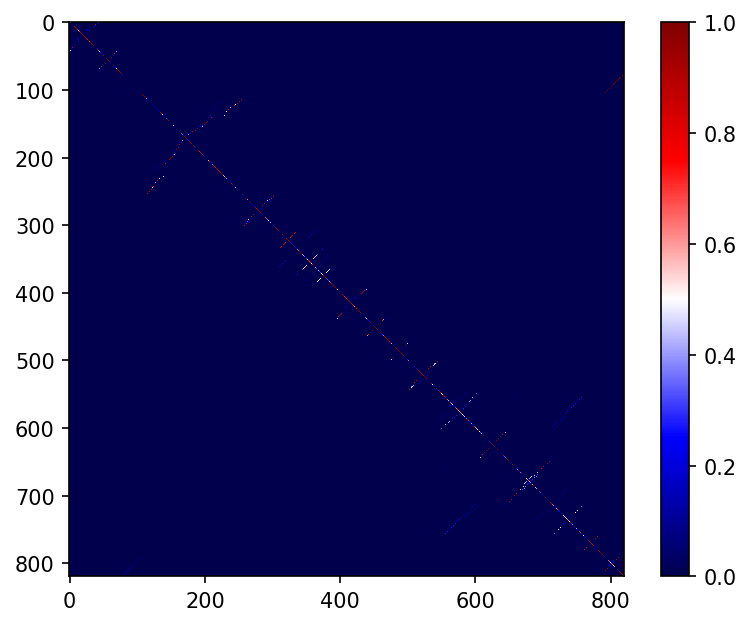

In [606]:
plt.figure(dpi=150)
plt.imshow(tube_results[tbs[0]].ensemble_pair_fractions.to_array(),#list(tube_results.complexes.values())[3].pairs.to_array(), 
           interpolation='nearest', cmap='seismic')
plt.clim([0,1])
plt.colorbar()
plt.show()